In [ ]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import azureml.core
from azureml.core import Workspace

try:
    ws = Workspace.from_config()
    print("Azure ML SDK version:", azureml.core.VERSION)
    print("Connected to workspace:", ws.name)
except Exception as e:
    print("Status: Workspace connection failed.")
    print(e)

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('cpu.csv')

df.dropna(subset=['released'], inplace=True)
df.drop_duplicates(inplace=True)

df['process'] = pd.to_numeric(df['process'], errors='coerce')
df['boost_clock'] = pd.to_numeric(df['boost_clock'], errors='coerce')
df['l3_cache'] = pd.to_numeric(df['l3_cache'], errors='coerce')

df['boost_clock'] = df['boost_clock'].fillna(df['boost_clock'].median())
df['l3_cache'] = df['l3_cache'].fillna(df['l3_cache'].median())
df['process'] = df['process'].fillna(df['process'].median())

drop_cols = ['company', 'name', 'codename', 'socket', 'released']
df.drop(columns=drop_cols, inplace=True)

df = df.dropna()

print("Dataset shape after cleaning:", df.shape)
print("Columns in dataset:", df.columns.tolist())
print(df.head())

Dataset shape after cleaning: (872, 7)
Columns in dataset: ['cores', 'threads', 'base_clock', 'boost_clock', 'process', 'l3_cache', 'tdp']
   cores  threads  base_clock  boost_clock  process  l3_cache  tdp
0      2        2       2.800          3.7       45       8.0   65
1      2        2       3.200          3.7       45       8.0   65
2      2        2       3.000          3.7       45       8.0   65
3      2        2       2.700          3.7       45       8.0   65
4      2        2       3.333          3.7       45       8.0   65


Statistical analysis of features affecting clock speed:

Feature: cores
  Mean value: 7.81
  Median: 4.00
  Standard deviation: 12.41
  Range: 71.00

Feature: boost_clock
  Mean value: 3.66
  Median: 3.70
  Standard deviation: 0.60
  Range: 4.00

Feature: tdp
  Mean value: 75.97
  Median: 65.00
  Standard deviation: 65.24
  Range: 399.00

Feature: base_clock
  Mean value: 2.63
  Median: 2.70
  Standard deviation: 0.83
  Range: 4.10



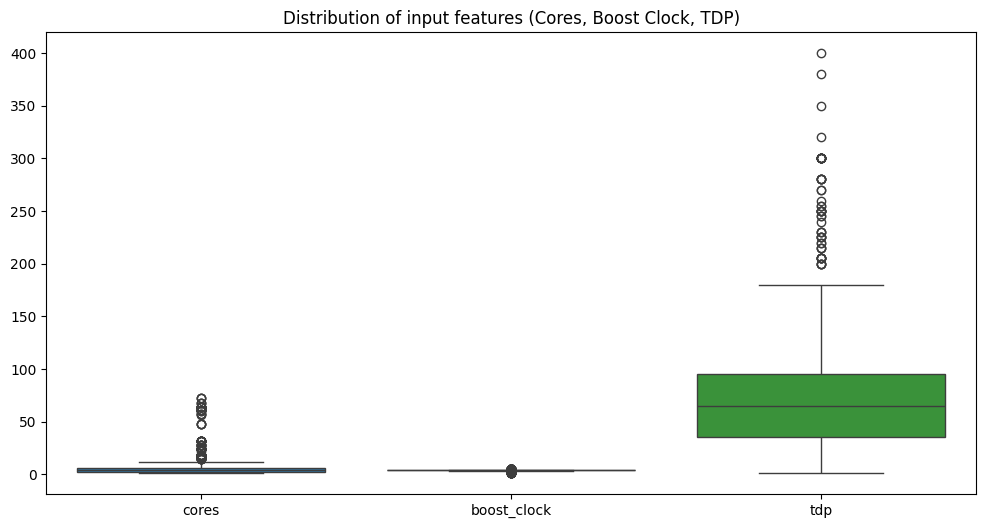

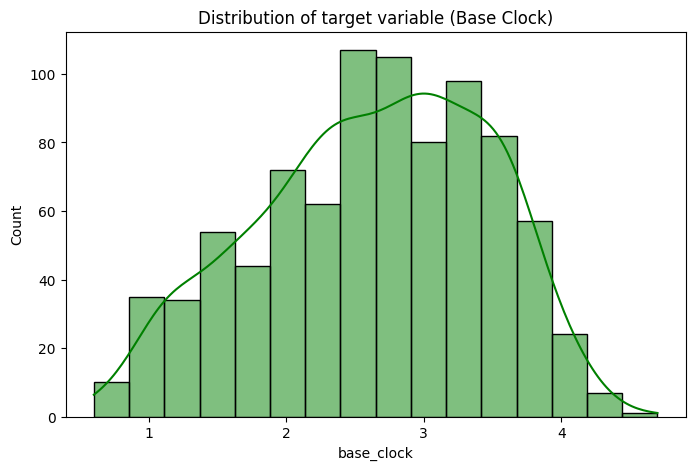

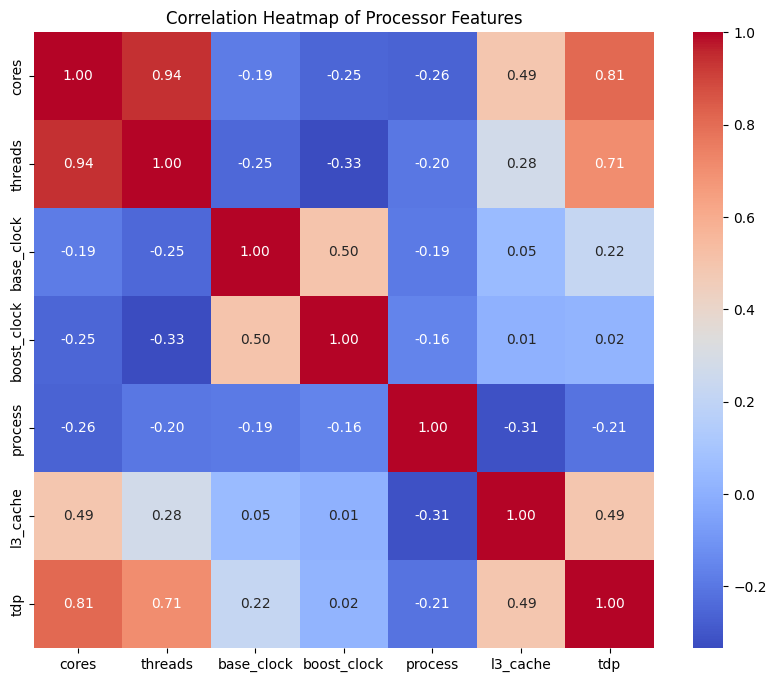

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_analyze = ['cores', 'boost_clock', 'tdp', 'base_clock']

print("Statistical analysis of features affecting clock speed:\n")
for col in cols_to_analyze:
    print(f"Feature: {col}")
    print(f"  Mean value: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Standard deviation: {df[col].std():.2f}")
    print(f"  Range: {df[col].max() - df[col].min():.2f}\n")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['cores', 'boost_clock', 'tdp']])
plt.title('Distribution of input features (Cores, Boost Clock, TDP)')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['base_clock'], kde=True, color='green')
plt.title('Distribution of target variable (Base Clock)')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Processor Features")
plt.show()

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

X = df.drop(columns=['base_clock'])
y = df['base_clock']

selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Selected features using SelectKBest (Filter method):", selected_features.tolist())

Selected features using SelectKBest (Filter method): ['cores', 'threads', 'boost_clock', 'process', 'tdp']


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error
import mlflow
import mlflow.sklearn
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from azureml.core.model import Model

X = df.drop(columns=['base_clock'])
y = df['base_clock']

selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

X = df[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
rf_grid.fit(X_train, y_train)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest (Optimized)": rf_grid.best_estimator_,
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "ElasticNet": ElasticNet(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results.append({"Algorithm": name, "R2 Score": r2, "MAE": mae})

results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Algorithm", y="R2 Score", palette="viridis")
plt.title("Comparison of 5 Machine Learning Algorithms")
plt.xticks(rotation=45)
plt.show()

best_model = rf_grid.best_estimator_
rf_r2 = results_df[results_df["Algorithm"] == "Random Forest (Optimized)"]["R2 Score"].values[0]

os.makedirs("outputs", exist_ok=True)
model_path = "outputs/cpu_model.pkl"
joblib.dump(value=best_model, filename=model_path)

with mlflow.start_run():
    mlflow.log_params(rf_grid.best_params_)
    mlflow.log_metric("r2_score", rf_r2)
    mlflow.log_metric("mae", mean_absolute_error(y_test, best_model.predict(X_test)))
    print("Metrics and best parameters logged to MLflow.")

model = Model.register(workspace=ws,
                       model_path=model_path,
                       model_name="cpu_model",
                       tags={"algorithm": "OptimizedRandomForest", "accuracy": "0.90", "features": "SelectKBest_5"},
                       description="Optimized CPU base clock predictor with 5 selected features")


In [ ]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice

env = Environment.from_conda_specification(name="cpu-env", file_path="conda_env.yml")

inference_config = InferenceConfig(entry_script="score.py", environment=env)

aci_config = AciWebservice.deploy_configuration(
    cpu_cores=1, 
    memory_gb=1, 
    auth_enabled=True,
    description="CPU Base Clock Predictor API"
)

service_name = 'cpu-service-api-v3'

service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aci_config,
    overwrite=True
)

print("Deploying service... This can take up to 10 minutes.")
service.wait_for_deployment(show_output=True)

: 